# Cleaning Data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.tree import plot_tree
# Evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.tree import plot_tree


In [2]:
df = pd.read_csv('copy.csv')
#This makes signup_os lower case and removes whitespace
df['signup_os'] = df['signup_os'].str.lower().str.strip()
#This makes signup_channel lower case and removes whitespace
df['signup_channel'] = df['signup_channel'].str.lower().str.strip()

#This makes all columns with date data to datetime
date_cols = ['bgc_date', 'vehicle_added_date', 'signup_date', 'first_completed_date']  # Removed 'first_trip_date' as it's not in the DataFrame

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

#This makes first_completed_date a boolean because we are measuring outcomes
df['started_driving'] = df['first_completed_date'].notna()
df['started_driving'] = df['started_driving'].astype(int)
# 2017 since newest vehicles in 2016 would be 2017 models
df['vehicle_age'] = 2017 - df['vehicle_year']

#This drops the id column because it is just an identifier
df.drop(columns=['id'], inplace=True)

#This drops vehicle_model because we are measuring outcomes
df.drop(columns=['vehicle_model'], inplace=True)


#This fills in missing values with 'unknown'
df['signup_os'] = df['signup_os'].fillna('unknown')

#This makes vehicle_info_missing a boolean 
df['vehicle_info_missing'] = df['vehicle_year'].isna().astype(int)

#This drops first_completed_date because we are measuring outcomes and it is no longer needed
df.drop(columns=['first_completed_date'], inplace=True)

#This creates onboarding_time which is the difference in days between bgc_date and signup_date
df['onboarding_time'] = (df['vehicle_added_date'] - df['signup_date']).dt.days

#This makes bgc_done a boolean
df['bgc_done'] = df['bgc_date'].notna().astype(int)

#This makes vehicle_age a float to -1
df['vehicle_age'] = df['vehicle_age'].fillna(-1)

#This makes onboarding_time a float to -1
df['onboarding_time'] = df['onboarding_time'].fillna(-1)

#This drops vehicle_year because we are measuring outcomes
df.drop(columns=['vehicle_year'], inplace=True)

df.to_csv('copy_updated.csv', index=False)

/tmp/ipykernel_1506/4277383013.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipykernel_1506/4277383013.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipykernel_1506/4277383013.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipykernel_1506/4277383013.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consis

In [3]:
# manually balance the dataset because there's such a huge imbalance between not driving vs driving
# 50/50 split 

df = pd.read_csv('copy_updated.csv')
drivers = df[df['started_driving'] == 1].sample(n=6000, random_state=42).copy()
non_drivers = df[df['started_driving'] == 0].sample(n=6000, random_state=42).copy()

df_combined = pd.concat([drivers, non_drivers], axis=0)
df_combined.to_csv('copy_combined.csv', index=False)

# Visualizing Data

In [34]:
df = pd.read_csv('copy_updated.csv')

#First Completed Driving Pie Chart
def plot_pie_first_driving():
    labels = [True, False]
    true_count = (df['started_driving'] == 1).sum()
    false_count = (df['started_driving'] == 0).sum()
    values = [true_count, false_count]
    fig = px.pie(values = values, names = labels, title='First Completed Driving')
    fig.show()

#Signup OS Pie Chart
def plot_pie_os():
    labels = ["windows", "mac", "ios web", "android web", "other", "unknown"]
    windows_count = (df['signup_os'] == "windows").sum()
    mac_count = (df['signup_os'] == "mac").sum()
    ios_count = (df['signup_os'] == "ios web").sum()
    android_count = (df['signup_os'] == "android web").sum()
    other_count = (df['signup_os'] == "other").sum()
    blank_count = (df['signup_os'] == "unknown").sum()
    values = [windows_count, mac_count, ios_count, android_count, other_count, blank_count]
    fig = px.pie(values = values, names = labels, title='Signup OS')
    fig.show()



plot_pie_first_driving()
plot_pie_os()


# Modeling

In [105]:
df = pd.read_csv('copy_combined.csv')
#Basic model
#LogisticRegression model to predict whether or not a new driver 
#who signs up will actually start driving (yes or no)

# smote = SMOTETomek(random_state=42)

lin_model = LogisticRegression(class_weight='balanced')

#Advanced model
#RandomForestClassifier model to 

# set bootstrap to true so that it uses a random subset of the input data
# i.e more variance in the each decision tree belonging to the random forest
reg_model = RandomForestClassifier(class_weight='balanced', bootstrap=True, max_features='sqrt')


# onehotencode the categorical columns 
# split the data using train_test_split
# y = target prediction (started_driving), x = every other column except started_driving
# fit the model
# print its accuracy, precision, etc.

df = pd.get_dummies(df, columns = ['signup_os', 'signup_channel'])

y = df['started_driving']
X = df.drop(columns=['started_driving', 'city_name', 'signup_date', 'bgc_date', 'vehicle_added_date', 'vehicle_make'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

linear_pipe = Pipeline([('scalar', StandardScaler()), ('classifier', lin_model)])
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
linear_pipe.fit(X_train, y_train)
y_pred = linear_pipe.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



reg_pipe = Pipeline([('classifier', reg_model)])
reg_pipe.fit(X_train, y_train)
y_pred = reg_pipe.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# train_pred = reg_pipe.predict(X_train)
# test_pred = reg_pipe.predict(X_test)

# from sklearn.metrics import classification_report, f1_score

# print("Train F1:", f1_score(y_train, train_pred))
# print("Test  F1:", f1_score(y_test, test_pred))




0.9304166666666667
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1200
           1       0.92      0.94      0.93      1200

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400

0.9183333333333333
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1200
           1       0.92      0.92      0.92      1200

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



# Model Diagram

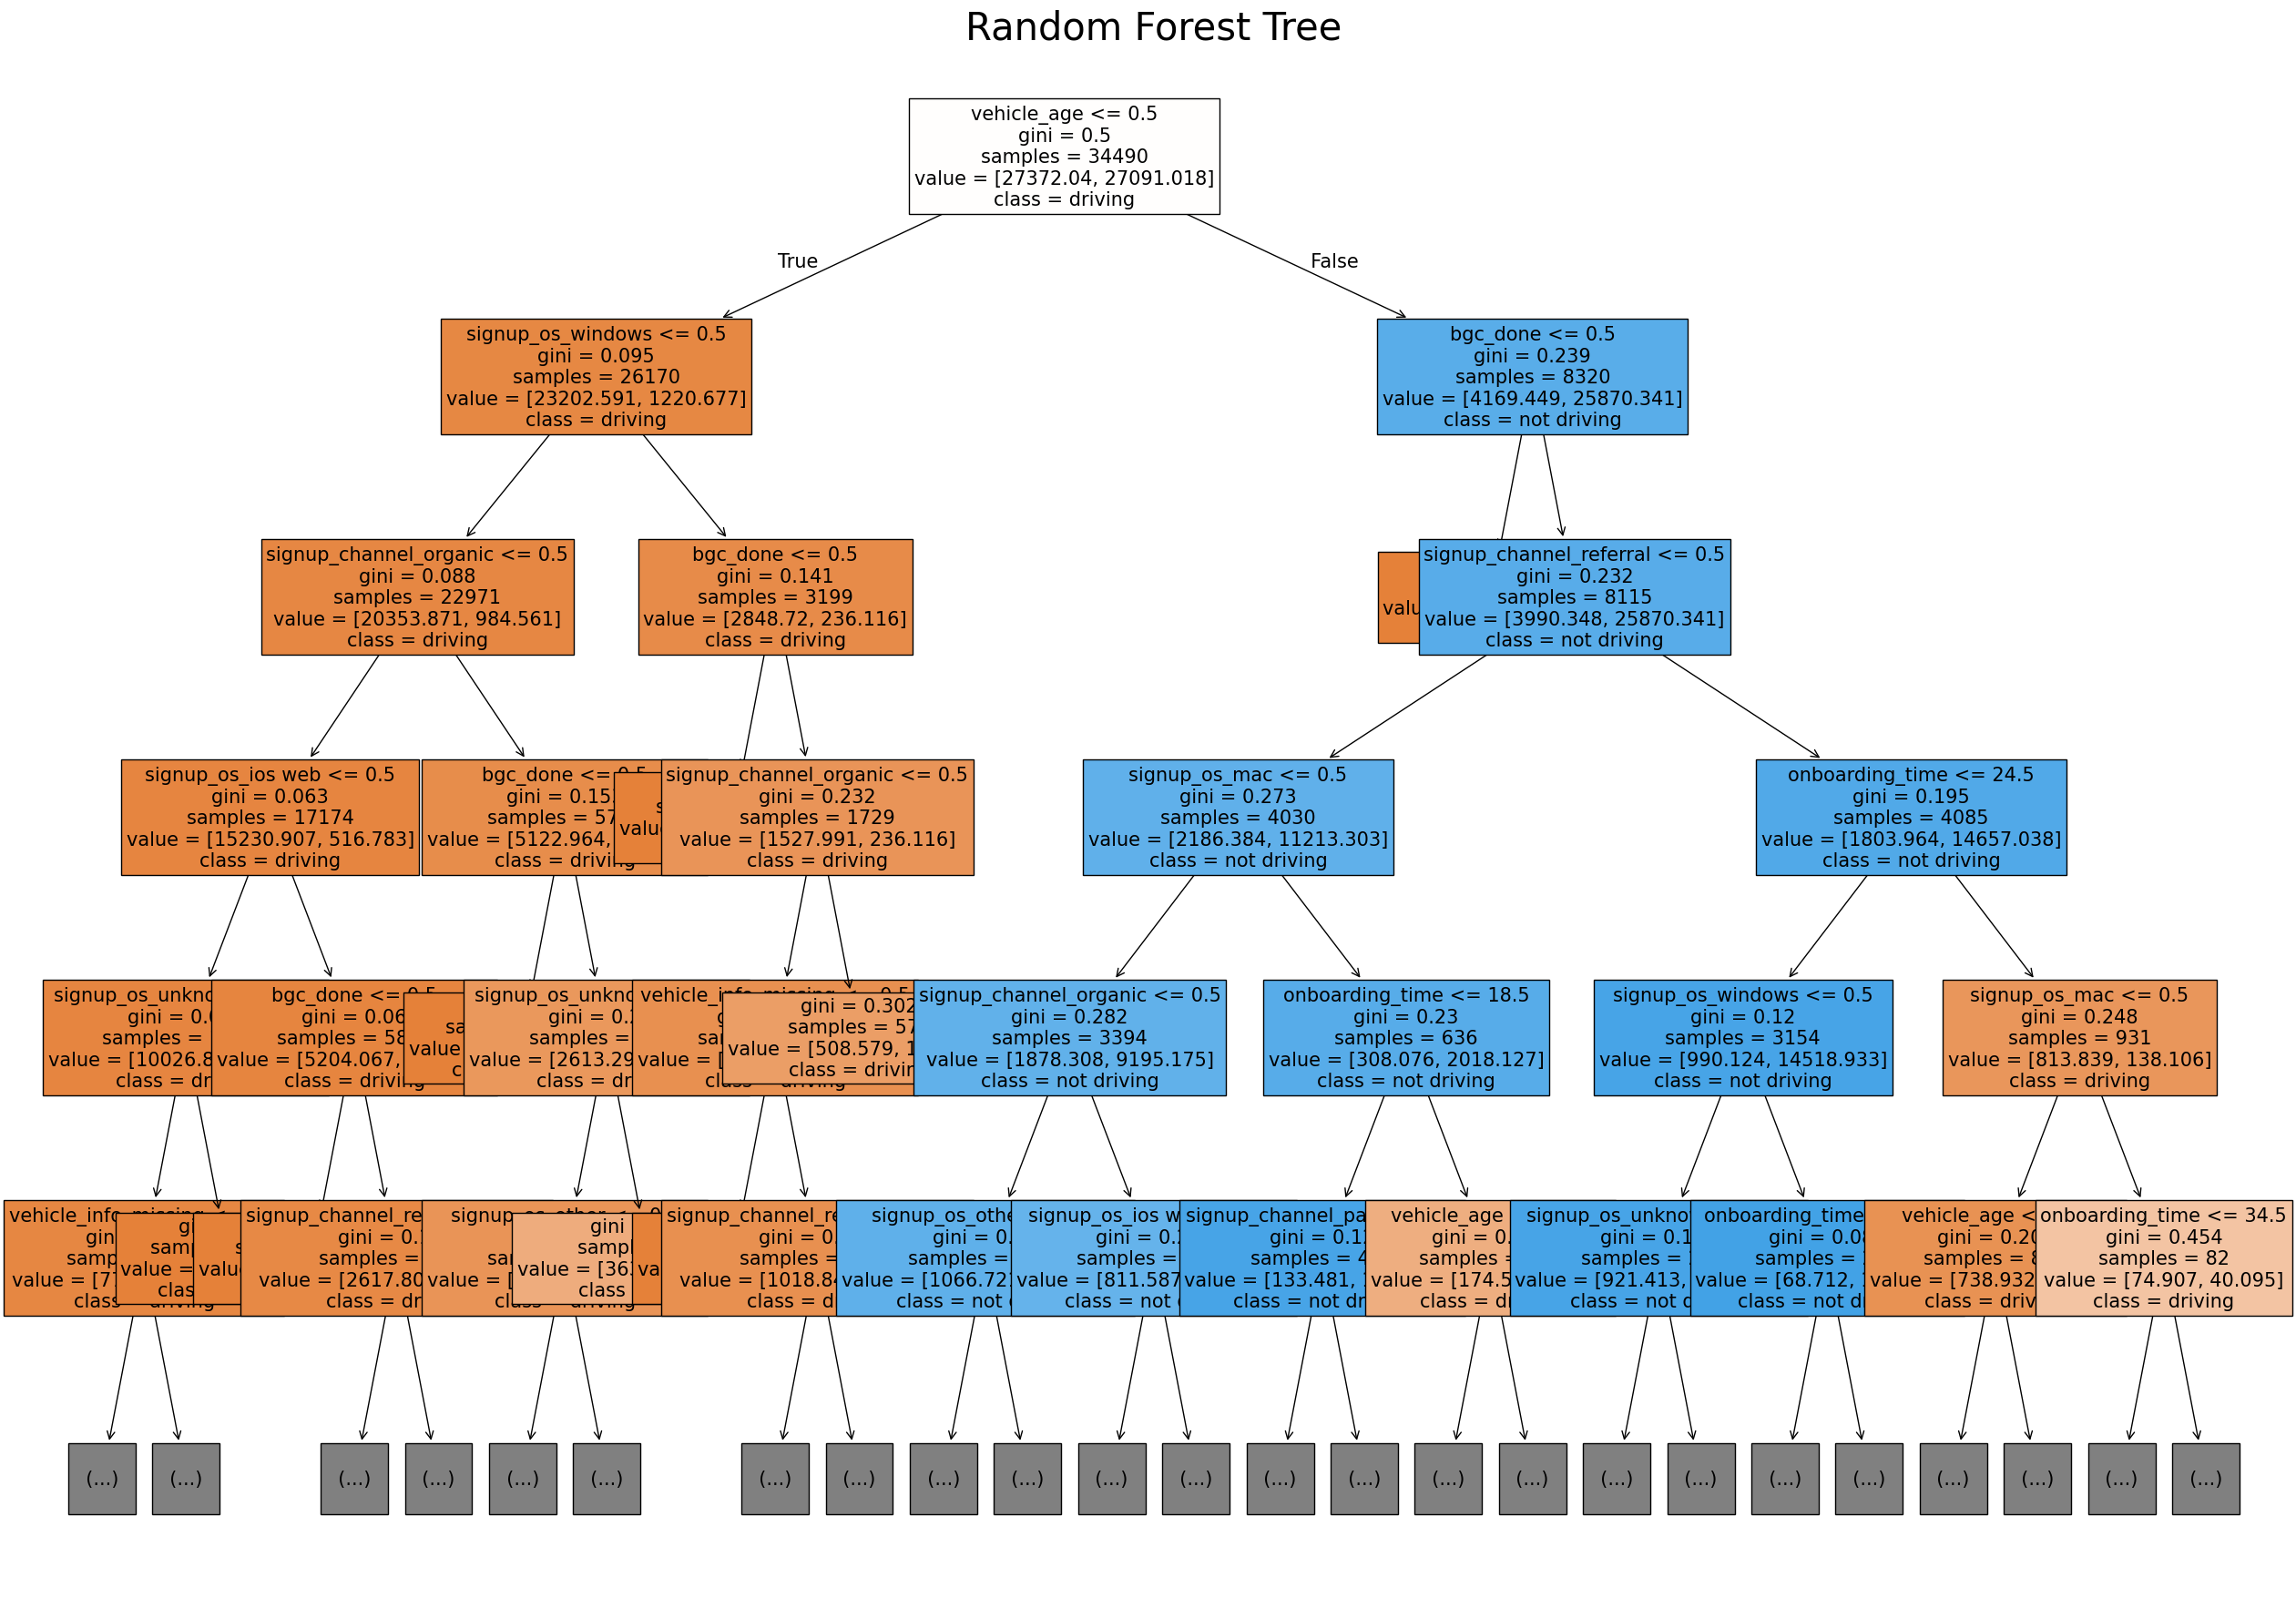

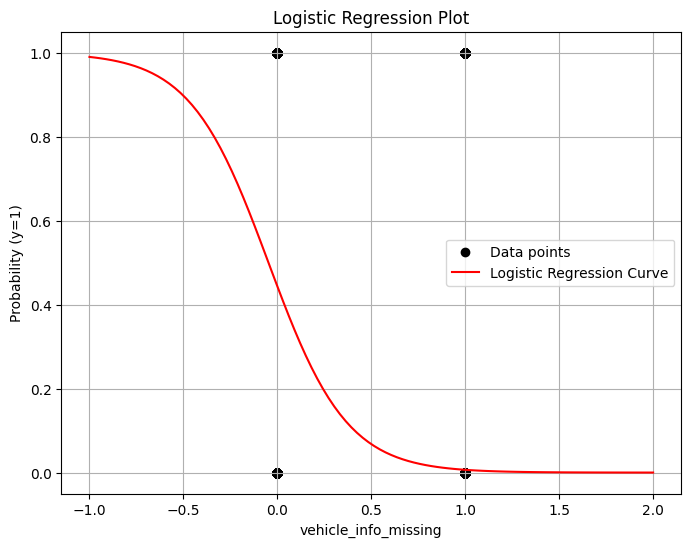

In [101]:
# Random Forest Tree

df = pd.read_csv('copy_updated.csv')
df = pd.get_dummies(df, columns = ['signup_os', 'signup_channel'])

y = df['started_driving']
X = df.drop(columns=['started_driving', 'city_name', 'signup_date', 'bgc_date', 'vehicle_added_date', 'vehicle_make'])
reg_model.fit(X, y)

estimator = reg_model.estimators_[0]

plt.figure(figsize=(31, 22))  # Bigger size
plot_tree(estimator, 
          feature_names=X.columns, 
          class_names=['driving','not driving' ],
          filled=True,
          max_depth=5, 
          fontsize=15)
plt.title("Random Forest Tree", fontsize=30)
plt.show()

# Logistic Regression Graph
model = LogisticRegression()
X = df[['vehicle_info_missing']]
y = df['started_driving']
model.fit(X, y)

# Creating a meaningful range for logistic regression visualization using the first feature
X_feature = X.iloc[:, 0].values.reshape(-1, 1)
X_range = np.linspace(X_feature.min() - 1, X_feature.max() + 1, 100).reshape(-1, 1)
model.fit(X_feature, y)  # Refitting model with one feature to simplify visualization
y_proba = model.predict_proba(X_range)

plt.figure(figsize=(8, 6))
plt.scatter(X_feature, y, color='black', label='Data points')
plt.plot(X_range, y_proba[:, 1], color='red', label='Logistic Regression Curve')
plt.xlabel('vehicle_info_missing')
plt.ylabel('Probability (y=1)')
plt.title('Logistic Regression Plot')
plt.legend()
plt.grid(True)
plt.show()

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1200
           1       0.92      0.94      0.93      1200

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400

🎯 ROC AUC Score: 0.968
✅ Accuracy Score: 0.932


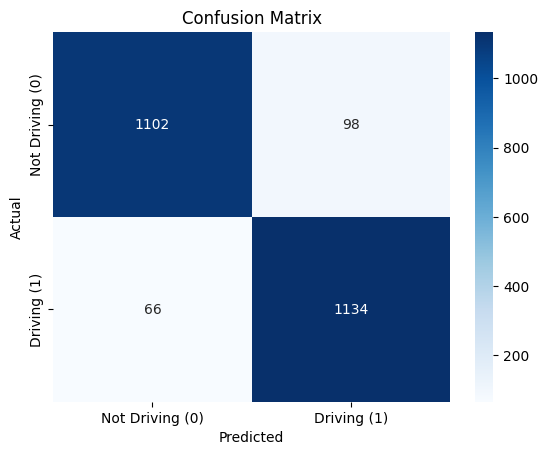

In [115]:
# === 1. Load and preprocess data ===
df = pd.read_csv('copy_combined.csv')

# Target and features
y = df['started_driving'].astype(int)
X = pd.get_dummies(df.drop(columns=['started_driving']), drop_first=True).fillna(0)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle class imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# === 2. Define final XGBoost model ===
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# === 3. Train and evaluate ===
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Classification report
print("📋 Classification Report:\n", classification_report(y_test, y_pred))
print(f"🎯 ROC AUC Score: {roc_auc_score(y_test, y_proba):.3f}")
print(f"✅ Accuracy Score: {accuracy_score(y_test, y_pred):.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Driving (0)', 'Driving (1)'],
            yticklabels=['Not Driving (0)', 'Driving (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

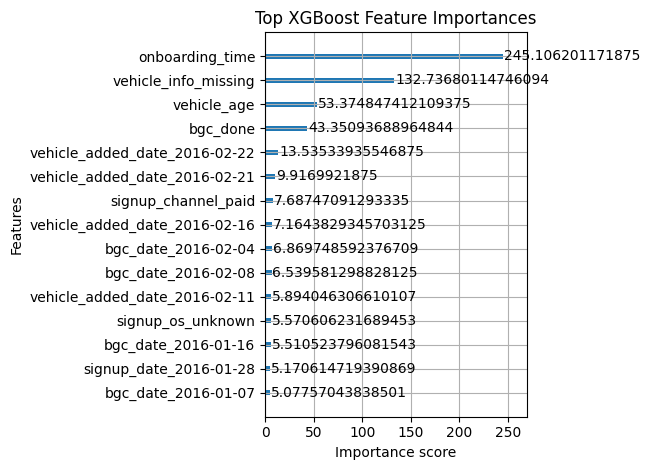

In [117]:
xgb.plot_importance(final_model, max_num_features=15, importance_type='gain')
plt.title("Top XGBoost Feature Importances")
plt.tight_layout()
plt.show()
#vehicle added date important because it is used by onboarding time


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=56ffd34a-2142-44ab-906c-9395a11c24a4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>